In [30]:
#pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cublas_cu12-12.4.5.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cuda_cupti_cu12-12.4.127-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/conda/lib/python3.12/site-packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pyp

In [31]:
%matplotlib widget

In [1]:
from GWAPWAi import *

In [2]:
observ_dict = reorganize_instructions(parse_file("test_input.in"))
flat_params, unpack_fn, static_params = pack_parameters(observ_dict, wave="P")
static_params["channel_names"] = observ_dict["channels"]["names"]
exp_data = load_data(observ_dict)

In [3]:
sqrt_s_grid, values, errors, masks, channel_list, model_channel_indices = prepare_data(exp_data, static_params)
s_vals_c = (sqrt_s_grid ** 2).to(dtype=torch.cdouble)

weight_vector = torch.tensor([
    observ_dict["fitting"]["InclChi2Weight"][0] if ch == "inclusive"
    else observ_dict["fitting"]["ExclChi2Weight"][0]
    for ch in channel_list
], dtype=torch.float64)

In [4]:
#move everything to device and precompute the integral (THIS IS THE ONLY EXPENSIVE CELL)

In [5]:
II = precompute_II(
    s_vals_c,
    static_params,
    integrate_rhoN_scp,
    rhoN_dispatcher,
    momentum,
    sheet = 0, #dont have implemented other than 0
    epsilon = 0.001,
    num_integ = 100
)

In [21]:
x_real_range=(113., 121.)
x_imag_range=(-1.5, 1.5)
Npts = 31
real_vals = torch.linspace(x_real_range[0], x_real_range[1], Npts)
imag_vals = torch.linspace(x_imag_range[0], x_imag_range[1], Npts)
# Crea le griglie 2D utilizzando torch.meshgrid
real_grid, imag_grid = torch.meshgrid(real_vals, imag_vals, indexing='ij')

# Combina le griglie in un tensore complesso
xfin = torch.complex(real_grid, imag_grid)
# Supponendo che xfin sia un tensore 2D di dimensioni (N, M)
xfin_col_flat = xfin.transpose(0, 1).flatten()

In [25]:
xfin_col_flat.shape

torch.Size([961])

In [27]:
complex_CM = precompute_II(
    xfin_col_flat,
    static_params,
    integrate_rhoN_scp,
    rhoN_dispatcher,
    momentum,
    sheet = 0, #dont have implemented other than 0
    epsilon = 0.001,
    num_integ = 100
)

In [28]:
test = compute_comp_amp(xfin_col_flat, flat_params, unpack_fn, static_params,
                      complex_CM,
                      numerator, omega_pole, 
                      construct_phsp, K_nominal, 
                      momentum)

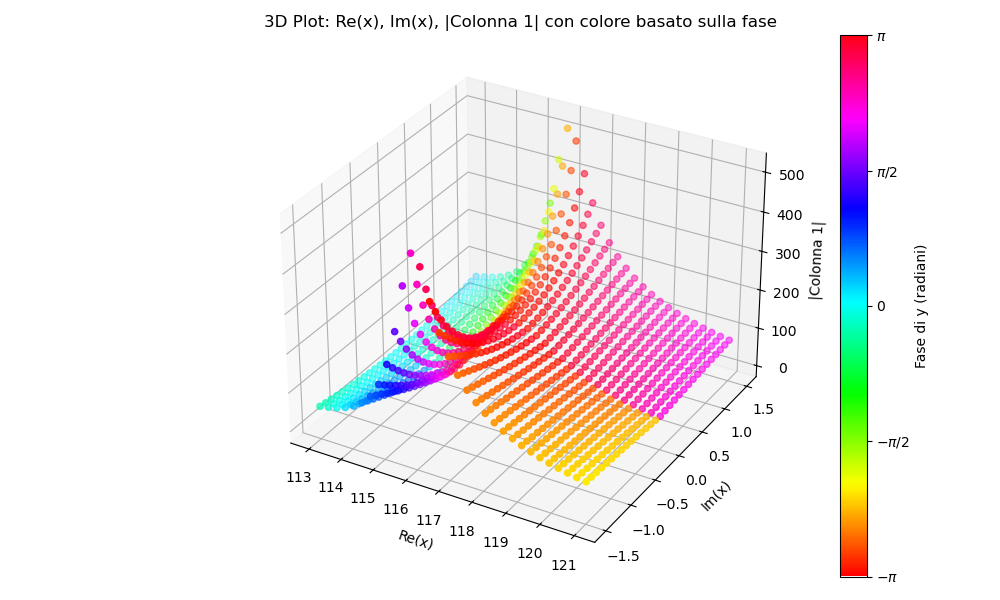

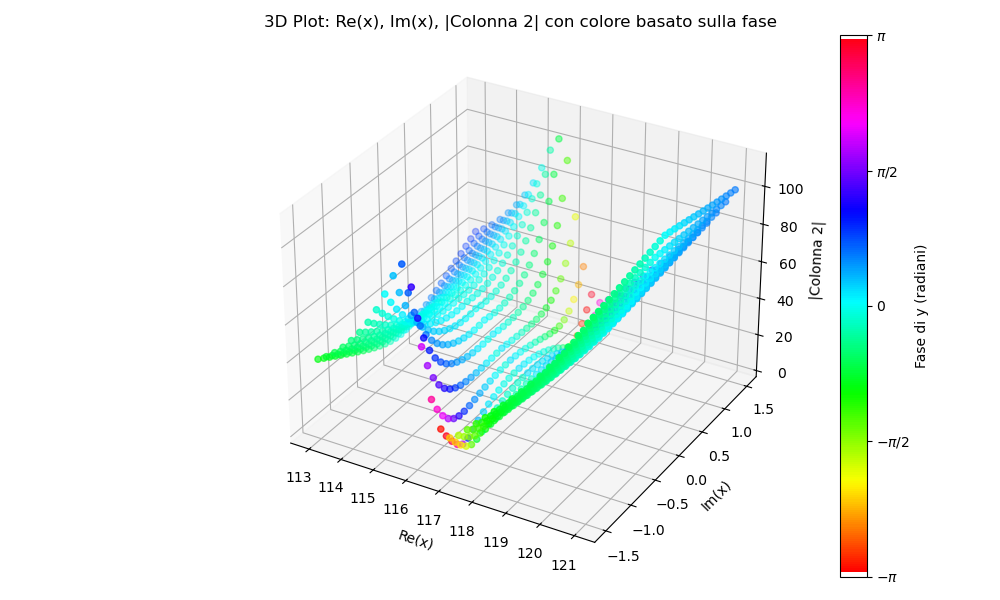

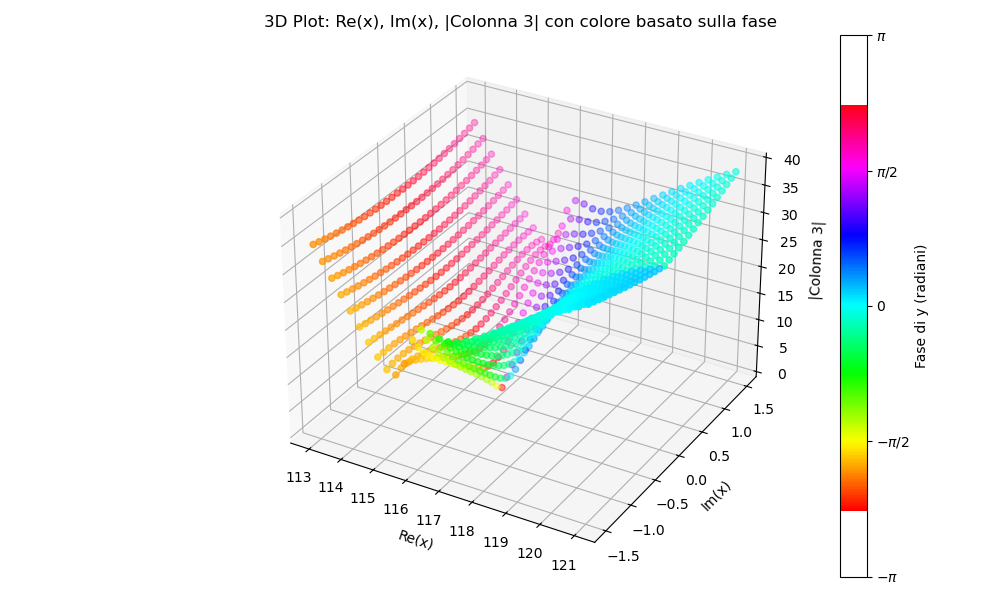

In [32]:
plot_complex_tensor_columns(
    xfin_col_flat,
    test
)

In [ ]:
# Set PyTorch to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#torch.set_default_device(device)

#default_device(device)

# Enable autograd anomaly detection for better error messages
torch.autograd.set_detect_anomaly(True)

In [ ]:
# Configure GPU memory management
if device.type == 'cuda':
    # Empty GPU cache
    torch.cuda.empty_cache()
    # Set a fixed seed for reproducibility
    torch.cuda.manual_seed(42)
    # Print GPU memory info
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

In [ ]:
for k, v in static_params.items():
    if isinstance(v, torch.Tensor):
        static_params[k] = v.to(device)
flat_params = randomize_initial_params(observ_dict, unpack_fn, wave="P").to(device)

In [ ]:
model = ChiSquaredLossModule(
    initial_params=flat_params,
    unpack_fn=unpack_fn,
    static_params=static_params,
    s_vals_c=s_vals_c.to(flat_params.device),
    II=II.to(flat_params.device),
    values=values.to(flat_params.device),
    errors=errors.to(flat_params.device),
    masks=masks.to(flat_params.device),
    model_channel_indices=model_channel_indices.to(flat_params.device),
    weight_vector=weight_vector.to(flat_params.device),
    compute_intensity_func=compute_intensity,
    numerator_func=numerator,
    omega_pole_func=omega_pole,
    construct_phsp_func=construct_phsp,
    K_nominal_func=K_nominal,
    momentum_func=momentum
).to(device)

In [ ]:
best_fit_params = run_fit(model, initial_params=flat_params, num_starts=50, adam_iters=50, lbfgs_iters=100, adam_lr=1e-2)

In [ ]:
sqrt_s_grid = sqrt_s_grid.to(device)
print(sqrt_s_grid.device, best_fit_params.device, next(model.parameters()).device)

In [ ]:
plot_fit_vs_data_full(
    best_fit_params=best_fit_params,
    model=model,
    sqrt_s_grid=sqrt_s_grid,
    values=values,
    errors=errors,
    masks=masks,
    channel_list=channel_list  # from prepare_exp_s_grid_and_data
)


In [ ]:
updated_observ_dict = update_dict(
    observ_dict=observ_dict,
    wave="P",
    flat_params=best_fit_params,
    unpack_fn=unpack_fn
)
updated_observ_dict